# Evolutionary Computation Assignment 1

- Krzysztof Szala 144571
- Vadym Repetskyi 155610


In [20]:
from utils import TspInstance
import math
import numpy as np
import pandas as pd

tsp_a = TspInstance("TSPA.csv")
tsp_b = TspInstance("TSPB.csv")

## Problem Instance Comparison


In [2]:
print("Average cost for an instance A:", np.mean(tsp_a.node_costs))
print("Average cost for an instance B:", np.mean(tsp_b.node_costs))

Average cost for an instance A: 978.165
Average cost for an instance B: 494.58


## Random Solution

Randomly select half of the nodes and shuffle them.


In [3]:
def random_solution(tsp: TspInstance):
    num_nodes = tsp.distance_matrix.shape[0]
    num_nodes_to_select = math.ceil(num_nodes / 2)
    selected_nodes = np.random.choice(num_nodes, num_nodes_to_select, replace=False)
    return selected_nodes

## Nearest Neighbor End

1. Start the _acyclic path_ with a random node.
2. While selected less than half of all nodes:
   1. Add a node that will increase the cost of the _acyclic path_ the least if added to the _end of the path_.

The cost is defined as the _sum of each node's cost and the distances between nodes_.


In [4]:
def nearest_neighbor_end(tsp: TspInstance):
    solution = [np.random.choice(tsp.size)]

    while len(solution) < np.ceil(tsp.size / 2):
        selected_node_index = min_cost = None

        for node_index in range(tsp.size):
            if node_index in solution:
                continue

            cost = tsp.get_cost(solution + [node_index])
            if min_cost is None or cost < min_cost:
                selected_node_index = node_index
                min_cost = cost

        solution.append(selected_node_index)

    return solution

## Nearest Neighbor Any

1. Start the _acyclic path_ with a random node.
2. While selected less than half of all nodes:
   1. Add a node that will increase the cost of the _acyclic path_ the least if added _anywhere in the path_.

The cost is defined as the _sum of each node's cost and the distances between nodes_.


In [5]:
def nearest_neighbor_any(tsp: TspInstance):
    solution = [np.random.choice(tsp.size)]

    while len(solution) < np.ceil(tsp.size / 2):
        selected_node_index = min_cost = None

        for node_index in range(tsp.size):
            if node_index in solution:
                continue

            for path_index in range(len(solution) + 1):
                test_solution = list(solution)
                test_solution.insert(path_index, node_index)

                cost = tsp.get_cost(test_solution)
                if min_cost is None or cost < min_cost:
                    selected_node_index = node_index
                    min_cost = cost

        solution.append(selected_node_index)

    return solution

## Greedy cycle

1. Initialize the _cycle_ with a _random node_ and _another node closest to it_.
2. While selected less than half of all nodes:
   1. Test the _difference in cycle cost_ introduced by inserting a node at _any possible place_.
   2. Insert the node minimazing the cost at the respective place.

The cost difference is defined as follows: _inserted_node_cost_ + _cost_of_added_connections_ - _cost_of_removed_connection_.


In [6]:
def greedy_cycle(tsp: TspInstance):
    solution = [np.random.choice(tsp.size)]
    solution.append(np.argmin(tsp.distance_matrix[solution[0]]))

    while len(solution) < np.ceil(tsp.size / 2):
        selected_node_index = min_cost = None

        for node_index in range(tsp.size):
            if node_index in solution:
                continue

            for path_index in range(len(solution) + 1):
                test_solution = list(solution)
                test_solution.insert(path_index, node_index)

                cost = tsp.get_cost(test_solution, cycle=True)
                if min_cost is None or cost < min_cost:
                    selected_node_index = node_index
                    min_cost = cost

        solution.append(selected_node_index)

    return solution

## Experiments


In [14]:
experiments = (
    tsp_a.run_experiments(random_solution, num_iterations=1),
    tsp_b.run_experiments(random_solution, num_iterations=1),
    tsp_a.run_experiments(nearest_neighbor_end, num_iterations=1),
    tsp_b.run_experiments(nearest_neighbor_end, num_iterations=1),
    tsp_a.run_experiments(nearest_neighbor_any, num_iterations=1),
    tsp_b.run_experiments(nearest_neighbor_any, num_iterations=1),
    tsp_a.run_experiments(greedy_cycle, True, num_iterations=1),
    tsp_b.run_experiments(greedy_cycle, True, num_iterations=1),
)

In [30]:
columns = (
    "Random A",
    "Random B",
    "NN-End A",
    "NN-End B",
    "NN-Any A",
    "NN-Any B",
    "Cycle A",
    "Cycle B",
)

pd.DataFrame(
    np.array(tuple(map(lambda x: x[:-1], experiments))).T,
    columns=columns,
    index=("min", "max", "avg"),
)

,Random A,Random B,NN-End A,NN-End B,NN-Any A,NN-Any B,Cycle A,Cycle B
min,253846.0,226037.0,78201.0,52495.0,107418.0,69357.0,121561.0,74529.0
max,253846.0,226037.0,78201.0,52495.0,107418.0,69357.0,121561.0,74529.0
avg,253846.0,226037.0,78201.0,52495.0,107418.0,69357.0,121561.0,74529.0


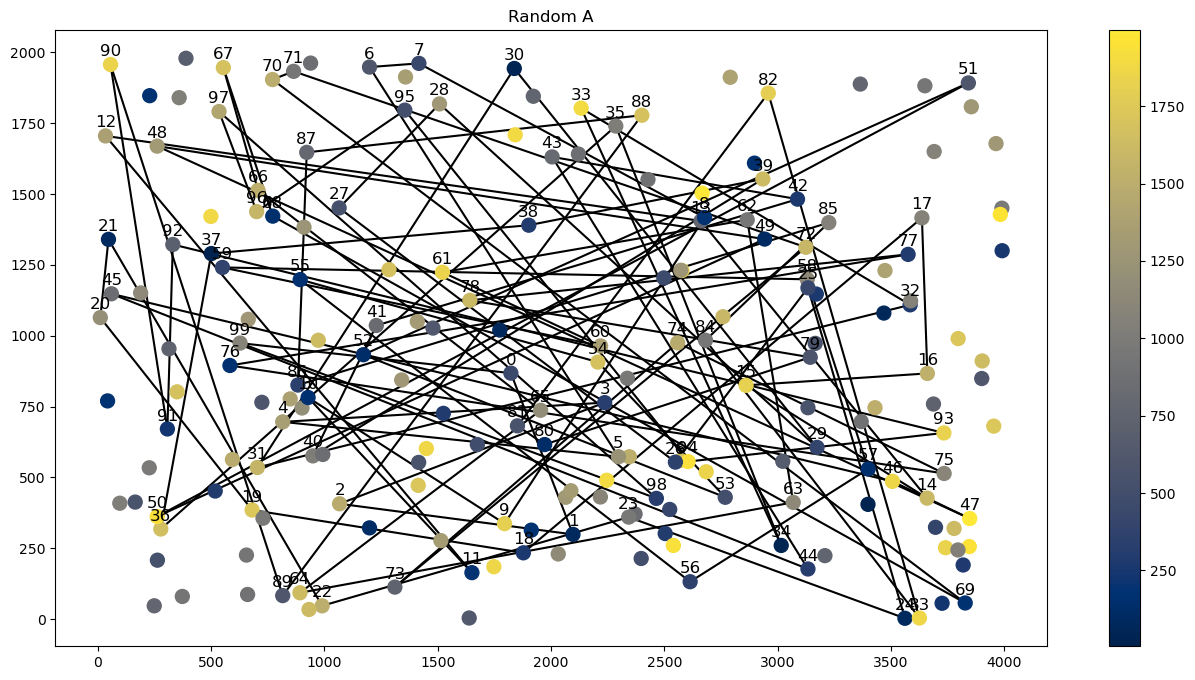

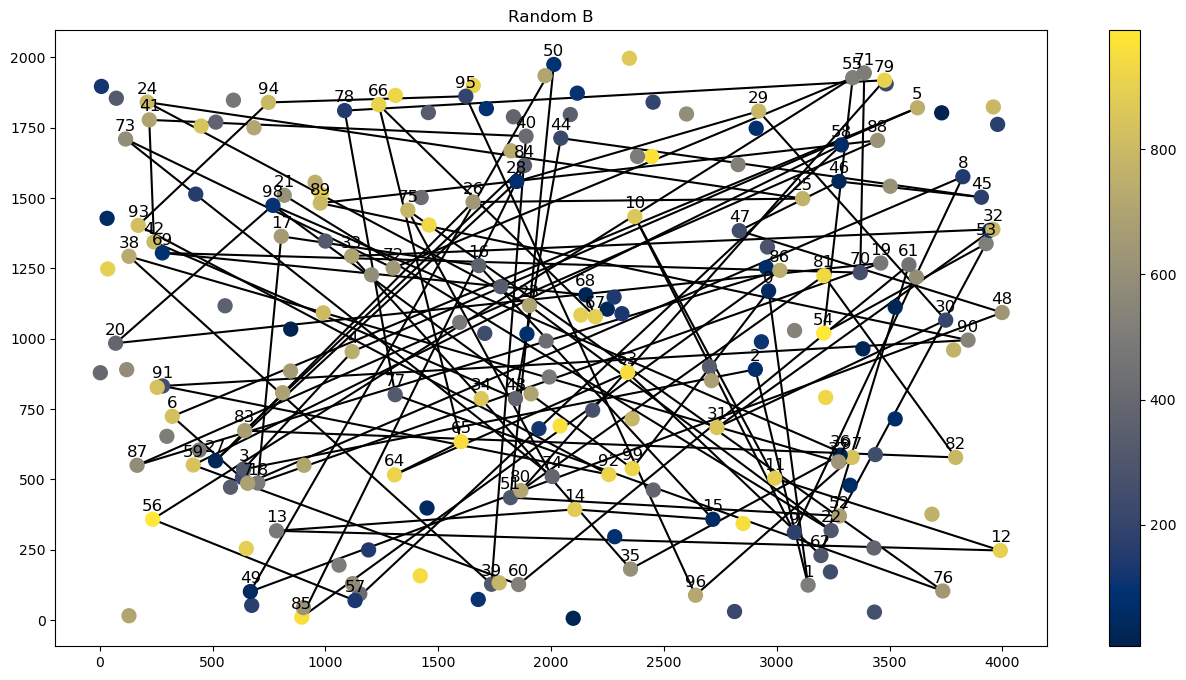

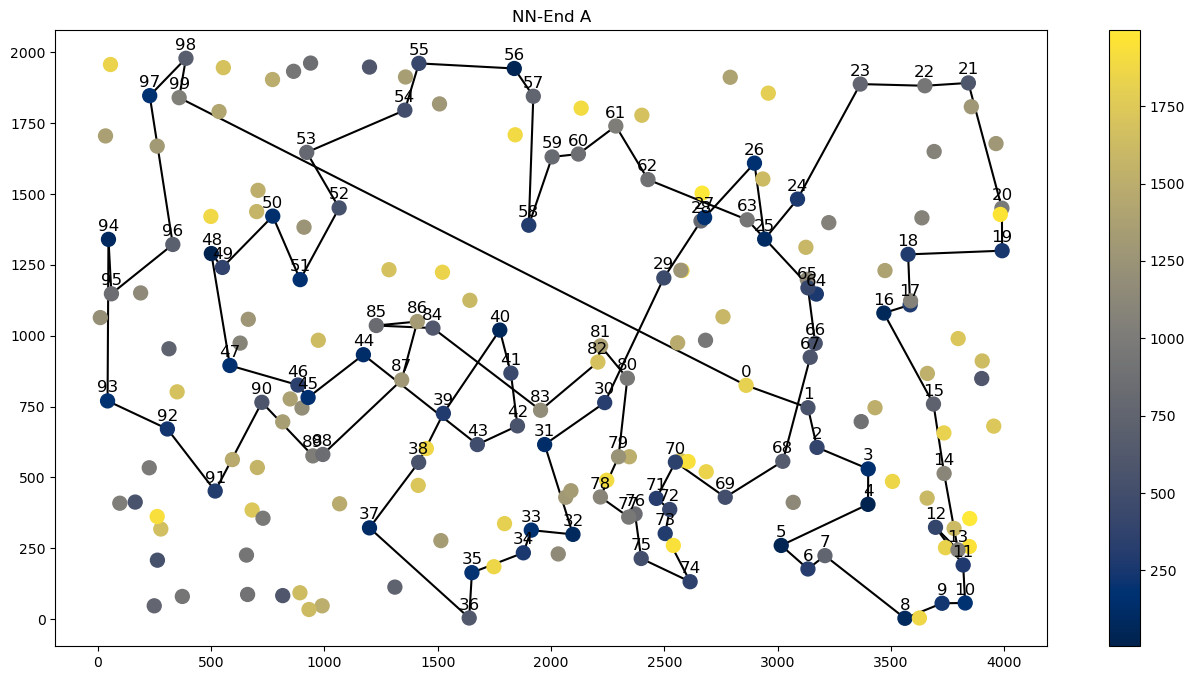

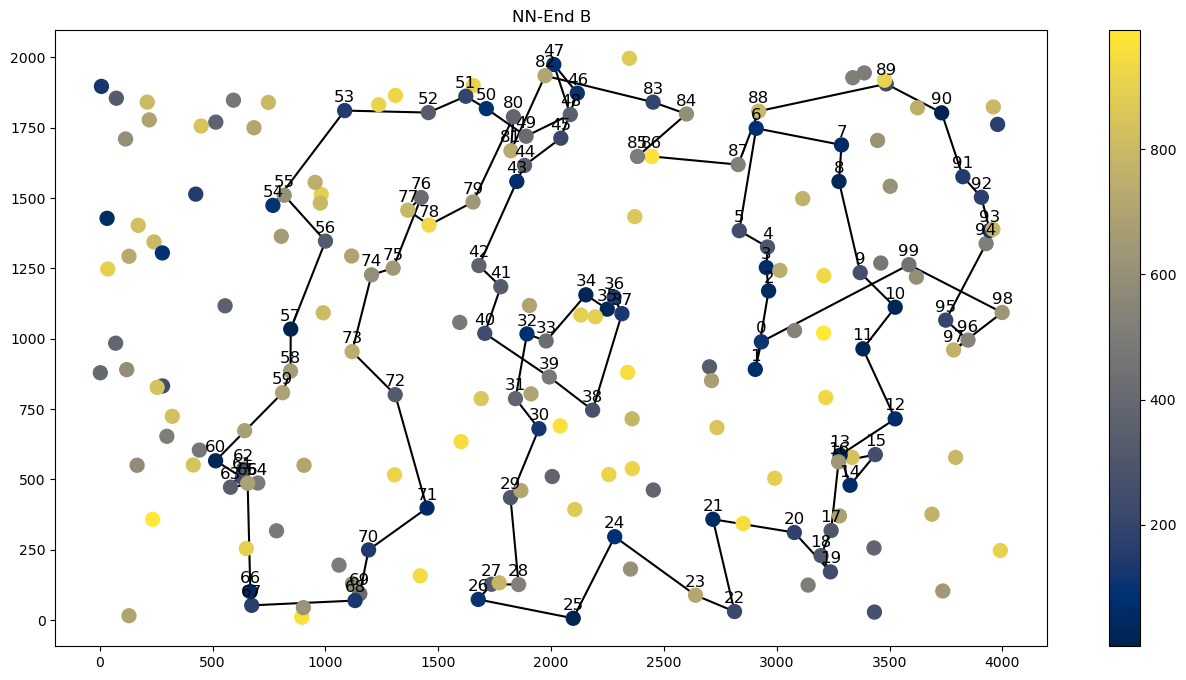

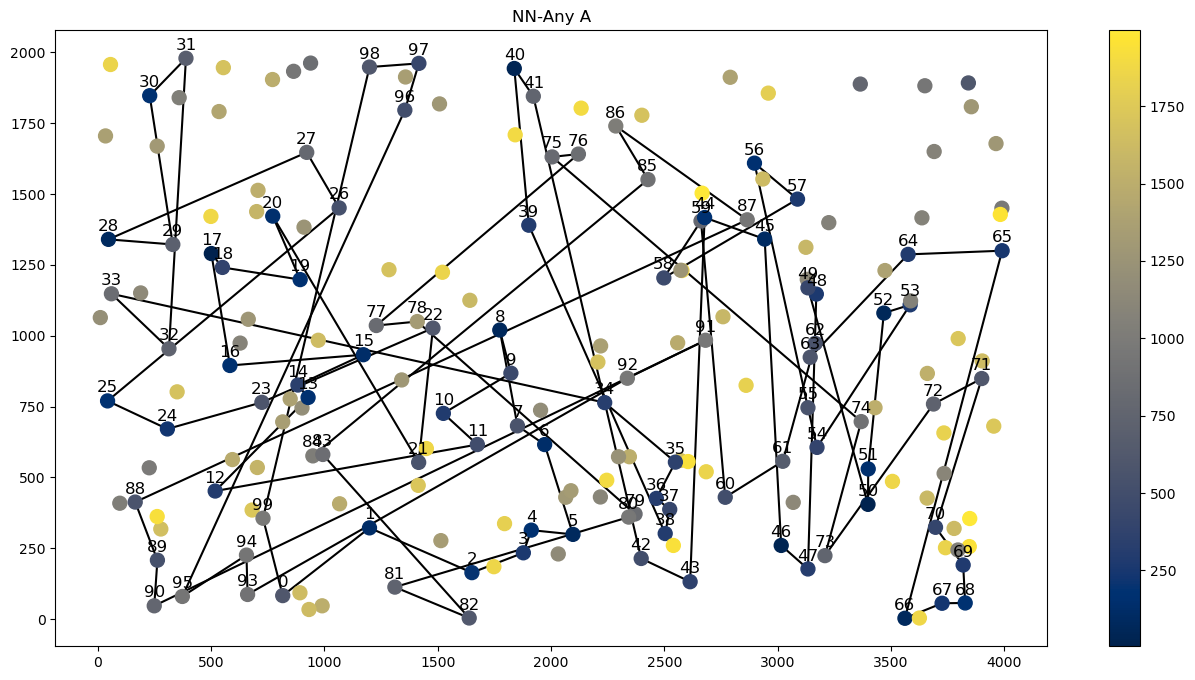

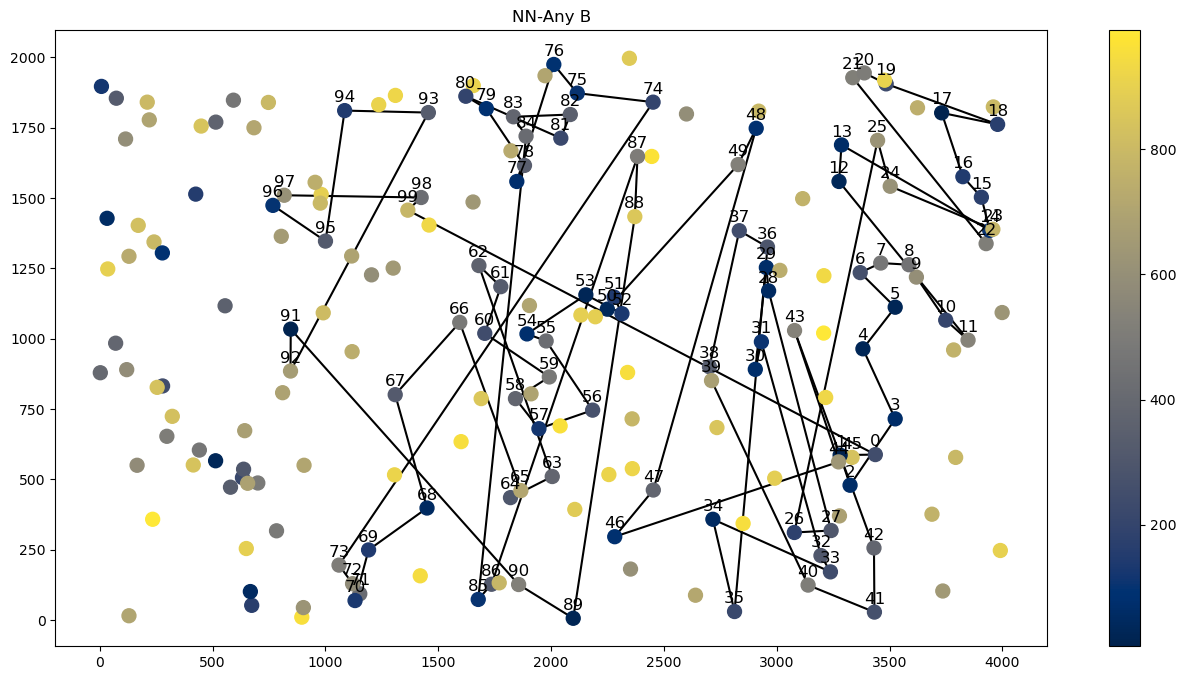

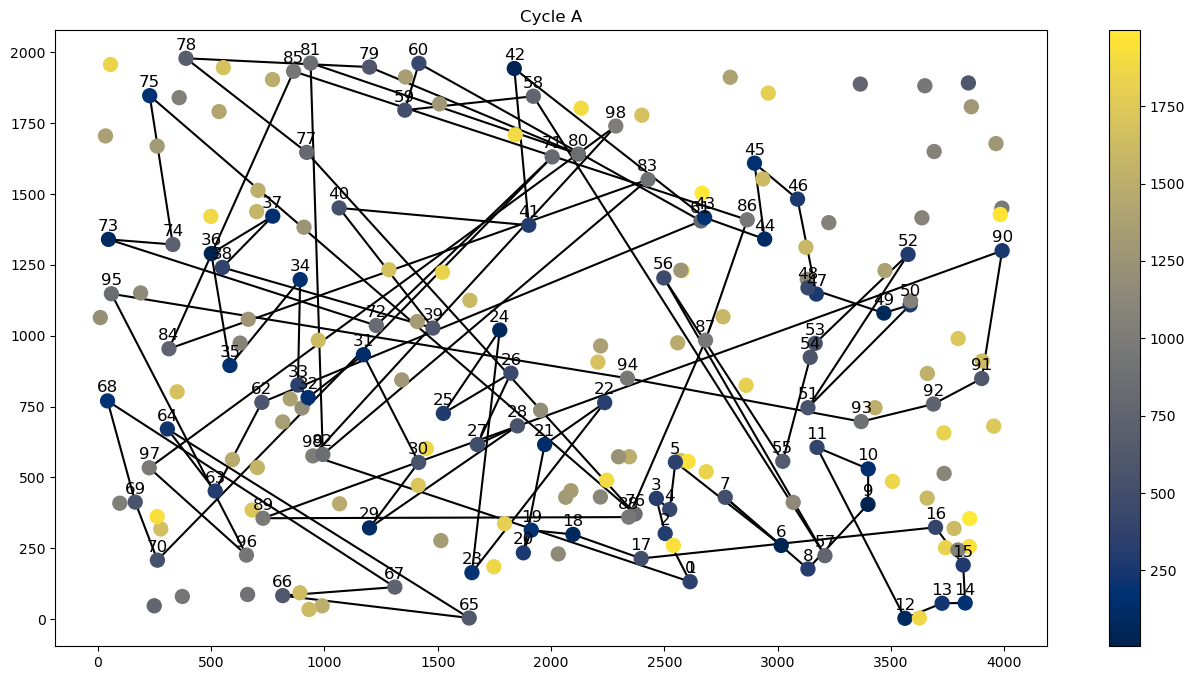

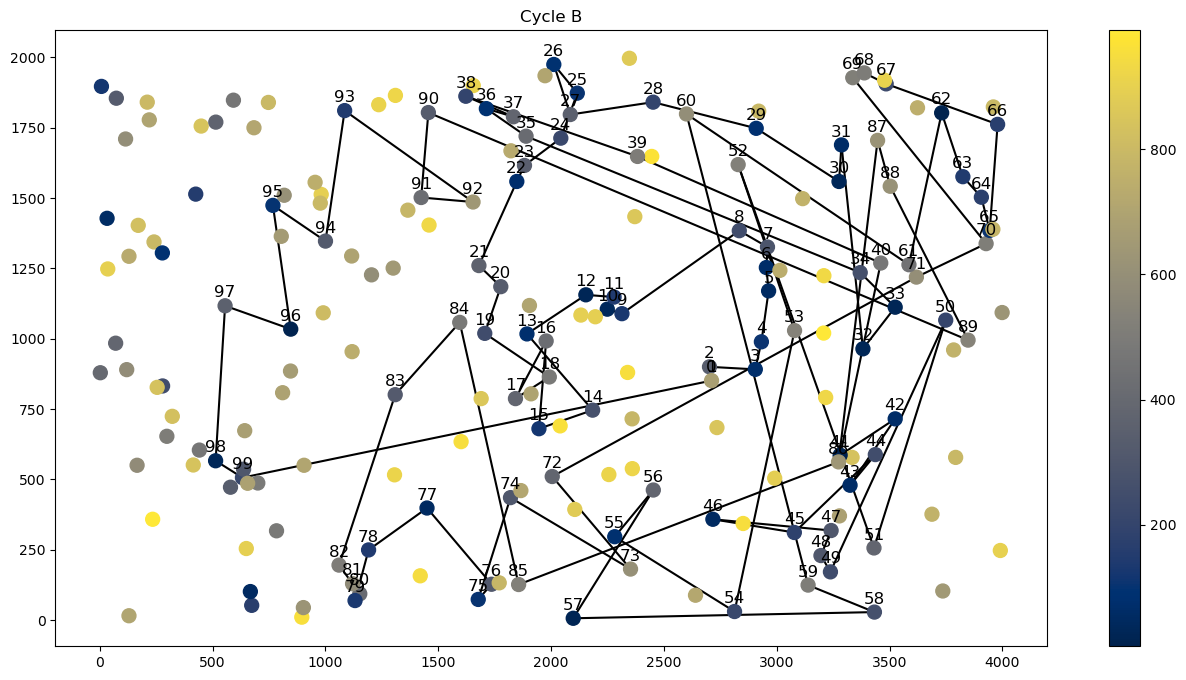

In [31]:
for index, ((_, _, _, solution), name) in enumerate(zip(experiments, columns)):
    if index % 2 == 0:
        tsp_a.plot(solution, name)
    else:
        tsp_b.plot(solution, name)

# Conclusions:

- Nearest neighbor considering adding the node only at the end of the current path (NN_end) - method had best results for both instance, ended with best solution
- Random solution didn't have a luck even for such small sample of nodes and work much worse
- For an instance B, NN_end and greedy cycle method get almost same results
- Average cost for an instance is almost two times higher for instance B, which can be an explanation, why the results of heuristics give us lower overall cost
- In general, we expected:
  - nearest neighbor - be quick and far better than random
  - greedy cycle - balance between speed and solution quality
- We get nn_end even better than greedy cycle
